Mounted at /content/drive
/content/drive/My Drive/Research/Google Collab Works/Data Preprocessing
✅ Dataset Loaded Successfully!


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

✅ Embeddings Generated! Shape: (1027, 768)

📌 Cluster-to-Emotion Mapping:
{0: 'Happy', 1: 'Surprise', 2: 'Surprise', 3: 'Disgust', 4: 'Surprise', 5: 'Sadness'}
✅ Corrected Dataset (Mislabeled Only) Saved as 'corrected_dataset_new.csv'!
✅ Full Labeled Dataset Saved as 'new_labeled_dataset.csv'!

🔍 Potentially Mislabeled Data:
                                               sentence original_label  \
0     "அவன் கம்ப்யூட்டர் இன்ஜினியருங்க. அவன் கேட்கறத...          Anger   
1     "கோவம் வந்தா கோழி P யில கை வைக்கனுமாம் " 😄😄 ஐய...          Anger   
2     "பஸ்ஸுக்குள்ளே ஃபோன் பேசி எல்லாரையும் தொந்தரவு...          Anger   
3     # குசு பான்ஸ் மன குமுறல்.இவனுக்கு ரசிகனாக இருப...          Anger   
4     #1319 "தன்னை உணர்த்தினும் காயும் பிறர்க்குநீர்...          Anger   
...                                                 ...            ...   
1019                இது மாறி நடக்கலைன்னா தான் ஆச்சரியம்       Surprise   
1020  இது வரை அதிமுக உப்ப தின்னுதான வளர்ந்த ? என்னடா...       Surprise   
1023  இ

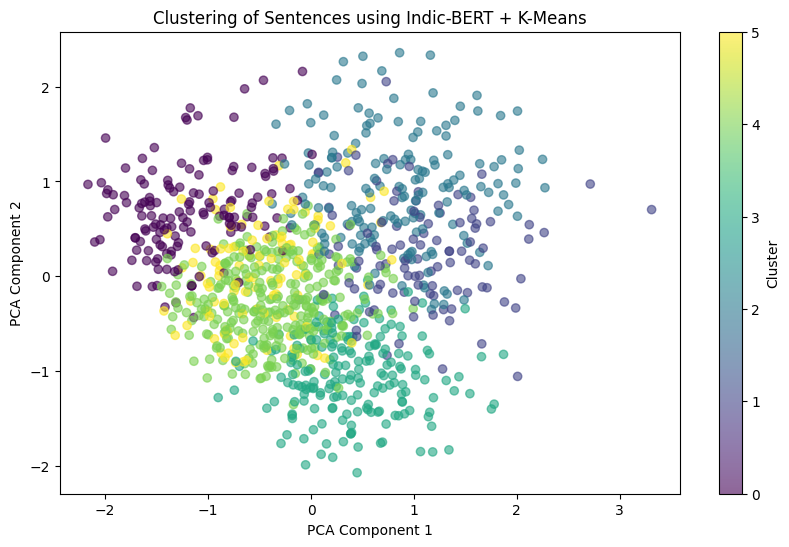

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Research/Google Collab Works/Data Preprocessing/



In [ ]:
# 1️⃣ Load Dataset
df = pd.read_csv("Tamil_Emotion_tweets.csv")  # Replace with actual CSV file
print("✅ Dataset Loaded Successfully!")

# Ensure dataset has correct columns
assert "sentence" in df.columns and "label" in df.columns, "Dataset must have 'sentence' and 'label' columns."

In [ ]:
# 2️⃣ Load Indic-BERT Model for Text Embeddings
model = SentenceTransformer("ai4bharat/indic-bert")

# Convert sentences into embeddings
embeddings = model.encode(df["sentence"].tolist(), convert_to_numpy=True)
print(f"✅ Embeddings Generated! Shape: {embeddings.shape}")  # (num_samples, 768)

In [ ]:
# 3️⃣ Apply K-Means Clustering (6 Clusters for 6 Emotions)
k = 6  # Since we expect 6 emotions
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(embeddings)


In [ ]:
# 4️⃣ Automatically Map Clusters to Emotions
# Count occurrences of each emotion in each cluster
cluster_label_counts = df.groupby(["cluster", "label"]).size().unstack(fill_value=0)

# Find the most common label in each cluster
cluster_to_emotion = cluster_label_counts.idxmax(axis=1).to_dict()
print("\n📌 Cluster-to-Emotion Mapping:")
print(cluster_to_emotion)

# Assign corrected labels based on clustering
df["predicted_label"] = df["cluster"].map(cluster_to_emotion)

In [ ]:
# 5️⃣ Identify Mislabeled Data
df["mislabeled"] = df["label"] != df["predicted_label"]

In [ ]:
# 6️⃣ Save Corrected Dataset (Only Mislabeled Data)
df[df["mislabeled"]].to_csv("corrected_dataset_new.csv", index=False)
print("✅ Corrected Dataset (Mislabeled Only) Saved as 'corrected_dataset_new.csv'!")

In [ ]:
# 7️⃣ Save the Full New Labeled Dataset (Original + Predicted Labels)
df.rename(columns={"label": "original_label"}, inplace=True)  # Rename original label column
df.to_csv("new_labeled_dataset.csv", index=False)
print("✅ Full Labeled Dataset Saved as 'new_labeled_dataset.csv'!")

In [ ]:
# 8️⃣ Display Mislabeled Rows
mislabeled_data = df[df["mislabeled"]]
print("\n🔍 Potentially Mislabeled Data:")
print(mislabeled_data[["sentence", "original_label", "predicted_label"]])

In [ ]:
# 9️⃣ Visualize Clusters (Optional)
pca = PCA(n_components=2)  # Reduce to 2D for visualization
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df["cluster"], cmap="viridis", alpha=0.6)
plt.colorbar(label="Cluster")
plt.title("Clustering of Sentences using Indic-BERT + K-Means")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
